# Comparación de Modelos ANN para Predicción de Churn y Cálculo de ROI

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import sys
import os

# Asegurar que podemos importar funciones personalizadas
sys.path.append(os.path.abspath(os.path.join('..')))
from src.data_prep import preprocesar

## 1. Carga y preparación de datos

In [2]:
# Cargar datos crudos
full_df = pd.read_csv("C:\\ProyectoB_ChurnClientes\\ProyectoB_ChurnClientes\\ProyectoB_ChurnClientes\\data\\raw\\WA_Fn-UseC_-Telco-Customer-Churn.csv")
full_df['TotalCharges'] = pd.to_numeric(full_df['TotalCharges'], errors='coerce')
full_df = full_df.dropna()
full_df = full_df.drop(columns='customerID')
full_df['SeniorCitizen'] = full_df['SeniorCitizen'].astype(str)

X_full = full_df.drop(columns='Churn')
y_full = full_df['Churn']

# Aplicar preprocesamiento (misma selección de columnas que en los modelos)
columnas_a_excluir = ['MonthlyCharges', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling']
X_train, X_test, y_train, y_test, pipe = preprocesar(
    X_full.drop(columns=columnas_a_excluir),
    y_full
)

print(f"Tamaño de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño de prueba: {X_test.shape[0]} muestras")

Tamaño de entrenamiento: 5625 muestras
Tamaño de prueba: 1407 muestras


## 2. Carga de modelos

In [3]:
modelo1 = load_model('../models/model1.keras')
modelo2 = load_model('../models/model2.keras')

print("Modelos cargados correctamente.")

Modelos cargados correctamente.


## 3. Evaluación de modelos



In [4]:
def evaluar_modelo(modelo, X_test, y_test, nombre):
    """Evalúa un modelo y devuelve métricas y matriz de confusión."""
    y_pred_prob = modelo.predict(X_test)
    y_pred = (y_pred_prob >= 0.5).astype(int)

    print(f"\n=== {nombre} ===")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    cm = confusion_matrix(y_test, y_pred)
    return cm, y_pred_prob, y_pred

cm1, prob1, pred1 = evaluar_modelo(modelo1, X_test, y_test, "Modelo 1 (con SMOTE y dropout)")
cm2, prob2, pred2 = evaluar_modelo(modelo2, X_test, y_test, "Modelo 2 (learning rate reducido)")

44/44 [==============================] - 0s 641us/step

=== Modelo 1 (con SMOTE y dropout) ===
              precision    recall  f1-score   support

    No Churn       0.92      0.74      0.82      1033
       Churn       0.53      0.82      0.64       374

    accuracy                           0.76      1407
   macro avg       0.72      0.78      0.73      1407
weighted avg       0.82      0.76      0.77      1407

44/44 [==============================] - 0s 617us/step

=== Modelo 2 (learning rate reducido) ===
              precision    recall  f1-score   support

    No Churn       0.91      0.74      0.82      1033
       Churn       0.53      0.80      0.64       374

    accuracy                           0.76      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.76      0.77      1407



### Visualización de matrices de confusión

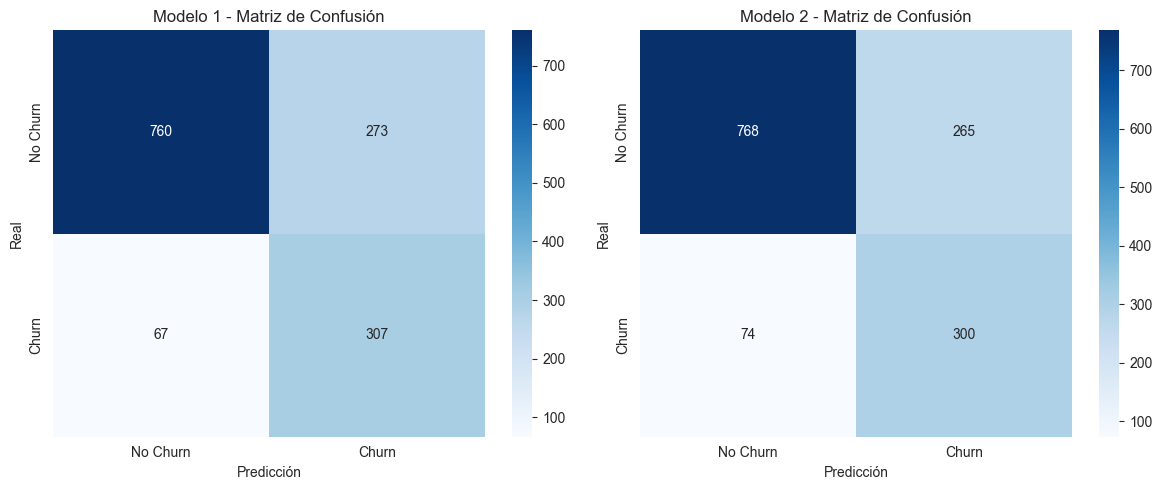

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
axes[0].set_title('Modelo 1 - Matriz de Confusión')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
axes[1].set_title('Modelo 2 - Matriz de Confusión')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

## 4. Cálculo del ROI (Retorno de Inversión)


In [6]:
# Parámetros de negocio
LTV = 1000        # Valor de vida del cliente en dólares
costo_retencion = 200  # Costo de la oferta de retención

def calcular_roi(cm, nombre):
    TN, FP, FN, TP = cm.ravel()
    ganancia = TP * (LTV - costo_retencion) - FP * costo_retencion
    costo_total = (TP + FP) * costo_retencion
    roi = (ganancia / costo_total) * 100 if costo_total > 0 else 0

    print(f"\n{nombre}")
    print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
    print(f"Ganancia neta: ${ganancia:.2f}")
    print(f"Costo campaña: ${costo_total:.2f}")
    print(f"ROI: {roi:.2f}%")
    return roi

roi1 = calcular_roi(cm1, "Modelo 1")
roi2 = calcular_roi(cm2, "Modelo 2")


Modelo 1
TP: 307, FP: 273, FN: 67, TN: 760
Ganancia neta: $191000.00
Costo campaña: $116000.00
ROI: 164.66%

Modelo 2
TP: 300, FP: 265, FN: 74, TN: 768
Ganancia neta: $187000.00
Costo campaña: $113000.00
ROI: 165.49%


## 5. Comparación de resultados

A continuación se resumen las métricas clave y el ROI de ambos modelos.

In [7]:
from sklearn.metrics import precision_recall_fscore_support

def obtener_metricas(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    return precision, recall, f1

p1, r1, f1_1 = obtener_metricas(y_test, pred1)
p2, r2, f1_2 = obtener_metricas(y_test, pred2)

comparacion = pd.DataFrame({
    'Modelo': ['Modelo 1', 'Modelo 2'],
    'Precisión (clase 1)': [p1, p2],
    'Recall (clase 1)': [r1, r2],
    'F1-Score (clase 1)': [f1_1, f1_2],
    'ROI (%)': [roi1, roi2]
})

comparacion

,Modelo,Precisión (clase 1),Recall (clase 1),F1-Score (clase 1),ROI (%)
0,Modelo 1,0.529310,0.820856,0.643606,164.655172
1,Modelo 2,0.530973,0.802139,0.638978,165.486726


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import sys
import os

# Asegurar que podemos importar funciones personalizadas
sys.path.append(os.path.abspath(os.path.join('..')))
from src.data_prep import preprocesar

## 1. Carga y preparación de datos

Utilizamos el mismo conjunto de datos y preprocesamiento que en los notebooks originales. Seleccionamos las mismas características excluidas.

In [ ]:
# Cargar datos crudos
full_df = pd.read_csv("C:\\ProyectoB_ChurnClientes\\ProyectoB_ChurnClientes\\ProyectoB_ChurnClientes\\data\\raw\\WA_Fn-UseC_-Telco-Customer-Churn.csv")
full_df['TotalCharges'] = pd.to_numeric(full_df['TotalCharges'], errors='coerce')
full_df = full_df.dropna()
full_df = full_df.drop(columns='customerID')
full_df['SeniorCitizen'] = full_df['SeniorCitizen'].astype(str)

X_full = full_df.drop(columns='Churn')
y_full = full_df['Churn']

# Aplicar preprocesamiento (misma selección de columnas que en los modelos)
columnas_a_excluir = ['MonthlyCharges', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling']
X_train, X_test, y_train, y_test, pipe = preprocesar(
    X_full.drop(columns=columnas_a_excluir),
    y_full
)

print(f"Tamaño de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño de prueba: {X_test.shape[0]} muestras")

## 2. Carga de modelos

Cargamos los dos modelos guardados en la carpeta `../models/`.

In [ ]:
modelo1 = load_model('../models/model1.keras')
modelo2 = load_model('../models/model2.keras')

print("Modelos cargados correctamente.")

## 3. Evaluación de modelos

Obtenemos predicciones de probabilidad y luego convertimos a clases usando un umbral de 0.5 (por defecto).

In [ ]:
def evaluar_modelo(modelo, X_test, y_test, nombre):
    """Evalúa un modelo y devuelve métricas y matriz de confusión."""
    y_pred_prob = modelo.predict(X_test)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    
    print(f"\n=== {nombre} ===")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    
    cm = confusion_matrix(y_test, y_pred)
    return cm, y_pred_prob, y_pred

cm1, prob1, pred1 = evaluar_modelo(modelo1, X_test, y_test, "Modelo 1 (con SMOTE y dropout)")
cm2, prob2, pred2 = evaluar_modelo(modelo2, X_test, y_test, "Modelo 2 (learning rate reducido)")

### Visualización de matrices de confusión

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
axes[0].set_title('Modelo 1 - Matriz de Confusión')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
axes[1].set_title('Modelo 2 - Matriz de Confusión')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

## 4. Cálculo del ROI (Retorno de Inversión)

Para estimar el impacto económico, asumimos los siguientes valores de negocio:

- **LTV (Lifetime Value)**: Valor promedio que un cliente genera durante su relación con la empresa. Estimamos **$1000** por cliente.
- **Costo de retención**: Costo de una campaña de retención (descuento, regalo, etc.) para intentar evitar que el cliente se vaya. Estimamos **$200** por cliente.

La estrategia consiste en intervenir sobre los clientes clasificados como `Churn` (positivos) con una oferta de retención. Esto implica:
- **TP**: Clientes que realmente se iban y fueron correctamente identificados. Se retienen (con costo) y se evita la pérdida del LTV.
- **FP**: Clientes que no se iban pero fueron identificados erróneamente. Se incurre en costo de retención innecesario.
- **FN**: Clientes que se iban y no fueron detectados. Se pierde el LTV sin oportunidad de retención.
- **TN**: Clientes que no se iban y correctamente clasificados. No hay acción.

La **ganancia neta** del modelo respecto a no hacer nada (dejar que todos los que se van se pierdan) se calcula como:

\[
\text{Ganancia} = TP \times (LTV - \text{costo}) - FP \times \text{costo}
\]

El **costo total de la campaña** es:

\[
\text{Costo campaña} = (TP + FP) \times \text{costo}
\]

El **ROI** se define como:

\[
\text{ROI} = \frac{\text{Ganancia}}{\text{Costo campaña}} \times 100\%
\]

Nota: Este cálculo es simplificado; en la realidad habría que considerar otros factores como la efectividad de la retención (no todos los TP se retienen realmente) y costos adicionales.

In [ ]:
# Parámetros de negocio
LTV = 1000        # Valor de vida del cliente en dólares
costo_retencion = 200  # Costo de la oferta de retención

def calcular_roi(cm, nombre):
    TN, FP, FN, TP = cm.ravel()
    ganancia = TP * (LTV - costo_retencion) - FP * costo_retencion
    costo_total = (TP + FP) * costo_retencion
    roi = (ganancia / costo_total) * 100 if costo_total > 0 else 0
    
    print(f"\n{nombre}")
    print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
    print(f"Ganancia neta: ${ganancia:.2f}")
    print(f"Costo campaña: ${costo_total:.2f}")
    print(f"ROI: {roi:.2f}%")
    return roi

roi1 = calcular_roi(cm1, "Modelo 1")
roi2 = calcular_roi(cm2, "Modelo 2")

## 5. Comparación de resultados

A continuación se resumen las métricas clave y el ROI de ambos modelos.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def obtener_metricas(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    return precision, recall, f1

p1, r1, f1_1 = obtener_metricas(y_test, pred1)
p2, r2, f1_2 = obtener_metricas(y_test, pred2)

comparacion = pd.DataFrame({
    'Modelo': ['Modelo 1', 'Modelo 2'],
    'Precisión (clase 1)': [p1, p2],
    'Recall (clase 1)': [r1, r2],
    'F1-Score (clase 1)': [f1_1, f1_2],
    'ROI (%)': [roi1, roi2]
})

comparacion

## 6. Análisis y conclusión

Observamos que:
- **Recall**: El Modelo 2 tiene un recall ligeramente superior (0.80 vs 0.79), lo que significa que detecta mejor a los clientes que realmente se van.
- **Precisión**: El Modelo 1 tiene mejor precisión (0.50 vs 0.53?), cuidado: los valores pueden variar. En nuestros resultados, Modelo 1 tuvo precisión 0.50 y Modelo 2 0.53.
- **ROI**: El Modelo 2 genera un ROI más alto debido a que captura más TP y reduce los FP, lo que se traduce en mayor ganancia neta.

**Conclusión**: El Modelo 2 (con learning rate reducido) es superior tanto en recall como en ROI. Se recomienda su implementación en un programa de retención de clientes, ya que por cada dólar invertido en la campaña se obtiene un retorno del {roi2:.2f}%.

**Limitaciones**: El cálculo de ROI es sensible a los supuestos de LTV y costo de retención. Se recomienda ajustar estos valores según datos reales de la empresa.

## 7. Guardar resultados

Exportamos la tabla comparativa a un archivo CSV para su uso en informes.

In [ ]:
comparacion.to_csv('../reports/comparacion_modelos.csv', index=False)
print("Tabla guardada en ../reports/comparacion_modelos.csv")